# Project Definition

## Project Overview

In my capstone project I am exploring the movements of stock prices and applying some machine learning technics, trying to predict the movements of stock prices.

**Data** I use is from yahoo finance. 
As input I take daily trading data: opening price (Open), highest price the stock traded at (High), how many stocks were traded (Volume) and closing price adjusted for stock splits and dividends (Adjusted Close).

First I am looking at the development of adj close stock prices by means of comparing and visualising different trading parameters: Daily returns, Cumulative returnes, Rolling statistics of mean, standard deviation and Bollinger Bands, as well as MACD and RSI. These parameters show, how risky (or volatile) are the stock prices, how profitable they are and what investing logic could be used. Several of these techniques indeed have some power to predict stock prices movements.

After looking at the trading parameters, I am going forward in my analysis of stock prices movements by means of machine learning models. First I am using Classifiers to predict if Adjusted Close price is going up or down the next day for single stock. After that I am using Regressor models trying to predict the value change. 
As features I am using the trading parameters I explored in the previous part and lag values of the previous days.
I am comparing different features,  looking which set of them and for which period have the highest predictive power.
I am also checking the models I would suggest to use for predictions for robustness, by testing them if different stocks and for different time periods. 


## Problem Statement

The main point of interest of my project it two explore the predictive power of machine learning techniques for the development of stock prices. As part of this task I am also looking for the features, that can be used in these models to make the predictins better.  


## Metrics

To measure the performance of my models I look how far are my predictions from the actual values.
To do this, I am comparing the predicted 'y' variable with the true 'y' variable of the test dataset.
Of cource I am always controlling that test dataset is later than train dataset on the timeline to avoid future bias.
I am calculating accuracy score by using the scoring methods of the machine learning models that I use.

# Analysis

## Data Exploration & Data Visualization

**Import data**

To import data from yahoo finance I am using yfinance (after installing it over 'pip install yfinance') for getting main data like open, high, low adj close prices per day for chosen symbols from yahoo finance<br>


In [5]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [6]:
# import necessary libraries

import yfinance as yf
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


import warnings
warnings.filterwarnings("ignore")

### Download chosen stocks from yahoo finance

In [7]:
# choose symbols for which to get data from yahoo finance, start and end date of the dataset
# I chose some symbols of the well-known american companies and american index: S&P 500, Apple, Airlines of America,
#Tesla, Ford, Microsoft and Google, Accenture plc, Amazon.com Inc., Johnson & Johnson, Pfizer, Exxon, Boeing, General Motors

symbols = (['SPY', 'AAPL', 'AAL', 'TSLA', 'F', 'MSFT', 'GOOGL', 'ACN', 'AMZN', 'JNJ', 'PFE', 'XOM', 'BA', 'GM', 'CSIQ'])
start_date = '2000-01-01'
end_date = '2020-10-20'

# downloading data from yahoo finance for the chosen parameters
df = yf.download(symbols, start_date, end_date)

[*********************100%***********************]  15 of 15 completed


### Look closer at the development of adjusted close prices of the chosen stocks

In [8]:
#general descriptive statistics
df[['Adj Close']].describe()

Adj Close                                                      \
               AAL         AAPL          ACN         AMZN           BA   
count  3792.000000  5234.000000  4844.000000  5234.000000  5234.000000   
mean     25.424681    16.657096    65.069412   445.702865    99.480083   
std      15.997623    21.352192    55.635030   669.316303    95.795368   
min       1.659225     0.201463     8.841002     5.970000    16.991474   
25%       9.349638     1.142289    21.819790    41.509998    37.653777   
50%      27.887225     7.685689    42.088449   131.190002    59.281029   
75%      39.426044    25.257773    94.576279   503.397507   119.899128   
max      59.345577   133.522247   244.620285  3531.449951   430.299988   

                                                                        \
              CSIQ            F           GM        GOOGL          JNJ   
count  3509.000000  5234.000000  2496.000000  4071.000000  5234.000000   
mean     16.608592     8.514924    28.020536   541.077660    64.189463   
std       9.056542     2.999104     6.123063   390.669072    35.687265   
min       2.030000     0.854121    14.530403    50.055054    19.993717   
25%      10.520000     6.192315    24.427306   241.453949    38.011455   
50%      15.630000     8.759873    27.787766   345.910919    45.800907   
75%      21.830000    10.391729    32.296901   800.250000    87.655512   
max      51.000000    17.018152    41.953167  1717.390015   151.821732   

                                                                        
              MSFT          PFE          SPY         TSLA          XOM  
count  5234.000000  5234.000000  5234.000000  2596.000000  5234.000000  
mean     41.305043    19.328995   138.397107    51.600934    47.521246  
std      41.097739     7.738906    71.642384    65.267107    17.494752  
min      11.554865     6.985306    53.329201     3.160000    16.709419  
25%      18.999169    13.260162    86.506500     7.201500    32.616449  
50%      22.317795    17.150997   105.910648    44.003000    49.867336  
75%      42.369045    25.136366   184.742954    59.637499    63.449572  
max     229.983139    39.802029   353.603485   498.320007    76.140144

In [9]:
# Define function to plot stock prices

def plot_data(df, symbols, title='Stock prices', ylabel='Price', y=0 , step=100, ax=None,
              start_date = '2000-01-01', end_date = '2020-10-20'):
    '''Plot stock prices
    INPUT:
    df - Dataframe
    title - title
    ylabel - label of y axis
    y - horizontal line, integer
    step - xticks step, integer
    OUTPUT: plot'''
    
    df1=df[start_date:end_date]
    ax = df1.plot(title=title, figsize=(16,8), ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.axhline(y=y, color='black')
    ax.legend(symbols, loc='upper left')
    try:
        plt.yticks(np.arange(0, df1.max().max()+step, step=step))
    except:
        pass
    plt.show()


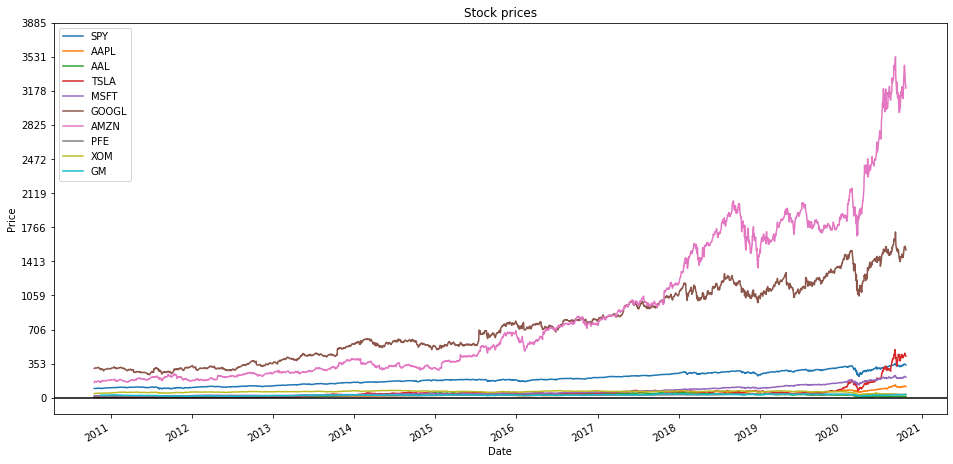

In [10]:
# Plot development of adj close stock prices for chosen companies
symbols = ['SPY', 'AAPL', 'AAL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'PFE', 'XOM', 'GM']
plot_data(df['Adj Close'][symbols]['2010-10-20':'2020-10-20'], symbols, title='Stock prices', ylabel='Price', y=0 , step=df['Adj Close'].max().max()/10)

By far the highest growth of the price we can see for Amazon and Google, but what about cumulative return?<br>
How much money could we get if we invested our money in these companies for 10 years?<br>
To answer this question I am normalizing data and plotting cumulative return for these companies.

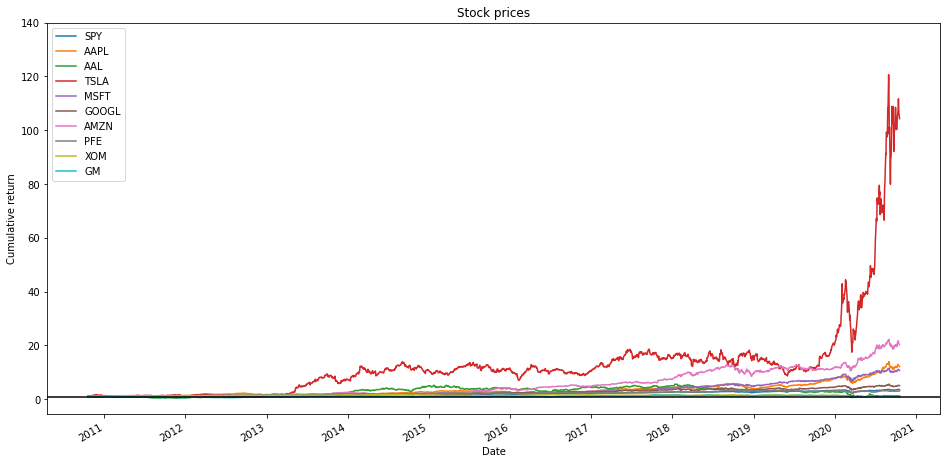

In [11]:
def normalize_data(df):
    '''normalize traiding data
    INPUT df - DataFrame   OUTPUT normalized DataFrame'''

    # In case if one of the stocks didnt exist on the start date  we will not get any line for such a company,
    # for this reason I am filling missing values. It will not bias the cumulative return as the price stays the same.
    
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True) 
    return df/df.iloc[0,:]

plot_data(normalize_data(df['Adj Close'][symbols]['2010-10-20':'2020-10-20']), symbols, ylabel='Cumulative return', step=20, y=1)
plt.show()

Looking at the cumulative return we could say that the absolutely highest return we could get if we invested in Tesla, if we invested in it at the beginning of it existance. The second place get Apple and Amazon, which also grew a lot over last years. By the way the growth of Apple and Amazon looks much more stable and less volatile. The most volatile and correspondingly risky stocks are from Tesla. It would be interesting to look how corona crises influenced the companies this year:

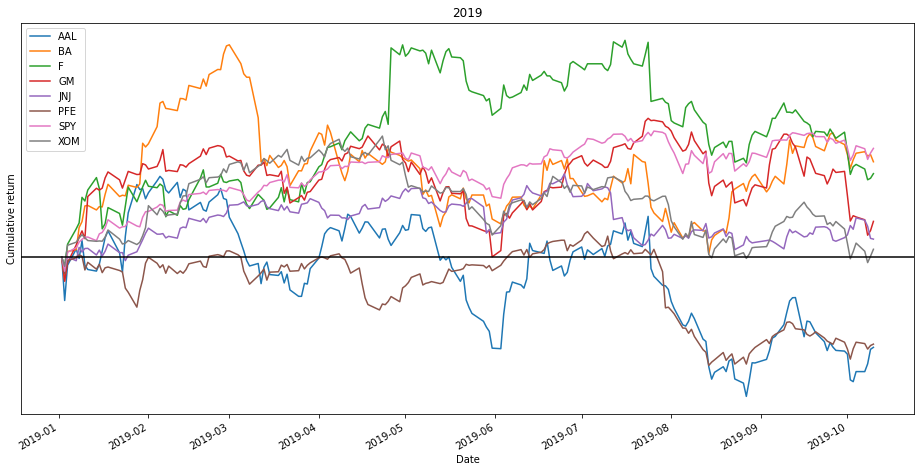

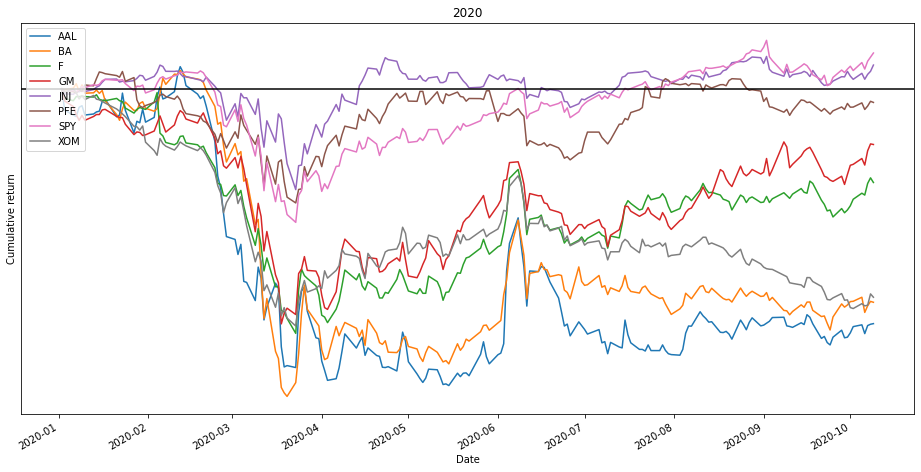

In [12]:
#first lets look at industry and health care companies

symbols = sorted(['SPY', 'AAL', 'F', 'JNJ', 'PFE', 'XOM', 'BA', 'GM'])

plot_data(normalize_data(df['Adj Close'][symbols]['2019-01-01':'2019-10-10']),  symbols, title='2019', ylabel='Cumulative return',  step=-0.1, y=1, start_date = '2019-01-01', end_date = '2019-10-10')
plt.show()
plot_data(normalize_data(df['Adj Close'][symbols]['2020-01-01':'2020-10-10']),  symbols, title='2020', ylabel='Cumulative return',  step=-0.1, y=1, start_date = '2020-01-01', end_date = '2020-10-10')
plt.show()

We can see that industry has very hard times this year as most cumulative returns are negative or are moving around zero in best case, in comparison to the last year where most of them had positive values for cumulative return. Now lets compare these values to the digital and innovative companies:

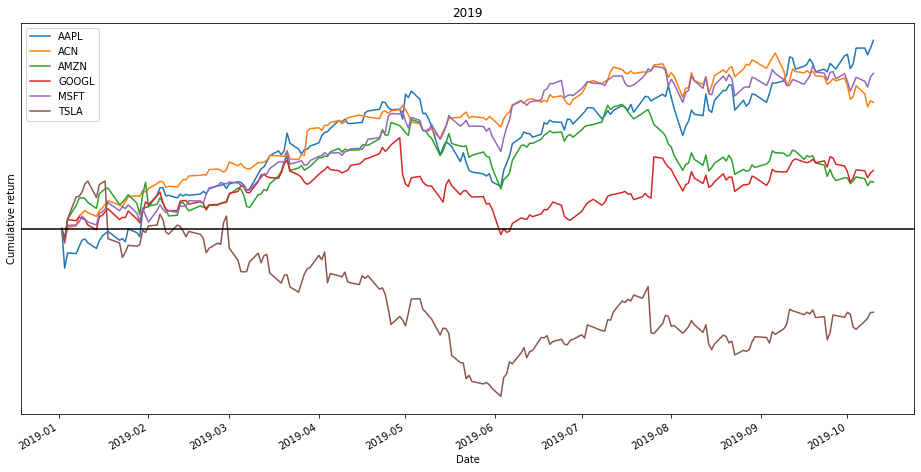

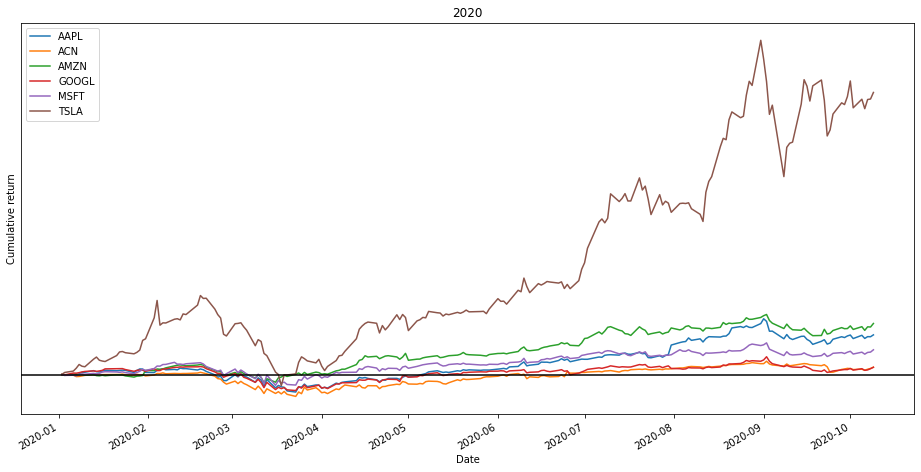

In [13]:
symbols = sorted(['AAPL', 'TSLA', 'MSFT', 'GOOGL', 'ACN', 'AMZN'])

plot_data(normalize_data(df['Adj Close'][symbols]['2019-01-01':'2019-10-10']),  symbols, title='2019', ylabel='Cumulative return',  step=-0.1, y=1, start_date = '2019-01-01', end_date = '2019-10-10')
plt.show()
plot_data(normalize_data(df['Adj Close'][symbols]['2020-01-01':'2020-10-10']),  symbols, title='2020', ylabel='Cumulative return',  step=-0.1, y=1, start_date = '2020-01-01', end_date = '2020-10-10')
plt.show()

As expected there was a small fall in spring, the first break down of corona, but after it all the comapynies show contineous groth.

Now I would like to look closer at the at the volatility of some stocks by means of rolling mean and Bollinger Bands.

### Looking at rolling mean/std and upper/lower bounds

In [14]:
# Plot rolling statistics for a chosen stock

symbol='AMZN'
def rolling_params(df, symbol, price_type, window=20):
    '''Create rolling mean, rolling standard deviation, upper_band and lower_band of 2 std
    INPUT:
    df - DataFrame
    symbol - stock
    window - how many days - the number of observations used for calculating the statistic
    price_type - type of price for which create rolling parameters
    OUTPUT: rolling mean, rolling standard deviation, upper_band and lower_band of 2 std'''
    
    values = df[(price_type, symbol)]
    rolling_mean = df[(price_type, symbol)].rolling(window=window).mean()
    rolling_std = df[(price_type, symbol)].rolling(window=window).std()
    upper_band = rolling_mean + rolling_std*2
    lower_band = rolling_mean - rolling_std*2
    return values, rolling_mean, rolling_std, upper_band, lower_band

        
def plot_rolling(symbol, values, rolling_mean, upper_band, lower_band, title='Rolling mean Adj Close 20 {}'.format(symbol)):
    '''Plot rolling mean and upper/lower bands of a stock
    INPUT:
    symbol - stock
    rolling_mean - rolling 20 days mean of the stock
    upper_band - upper band of the stock
    lower_band
    title - title
    OUTPUT: plot'''
    
    ax = rolling_mean.plot(title=title, figsize=(16,8), label='Rolling mean')
    plt.plot(upper_band, label='Upper band')
    plt.plot(lower_band, label='Lower band')
    plt.plot(values, label='Stock Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    plt.show()
    return ax


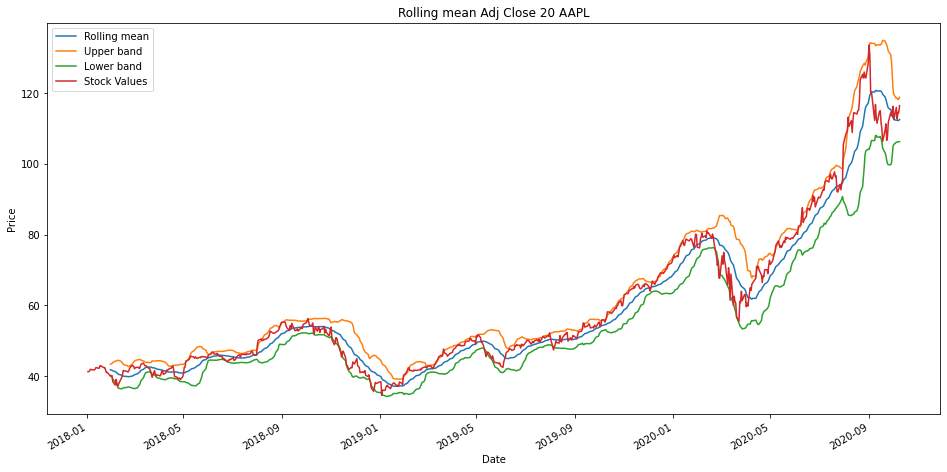

In [15]:
symbol='AAPL'
price_type = 'Adj Close'

values, rolling_mean, rolling_std, upper_band, lower_band = rolling_params(df['2018-01-01':'2020-10-10'], symbol, price_type)

plot_rolling(symbol, values, rolling_mean, upper_band, lower_band, title='Rolling mean Adj Close 20 {}'.format(symbol))
plt.show()

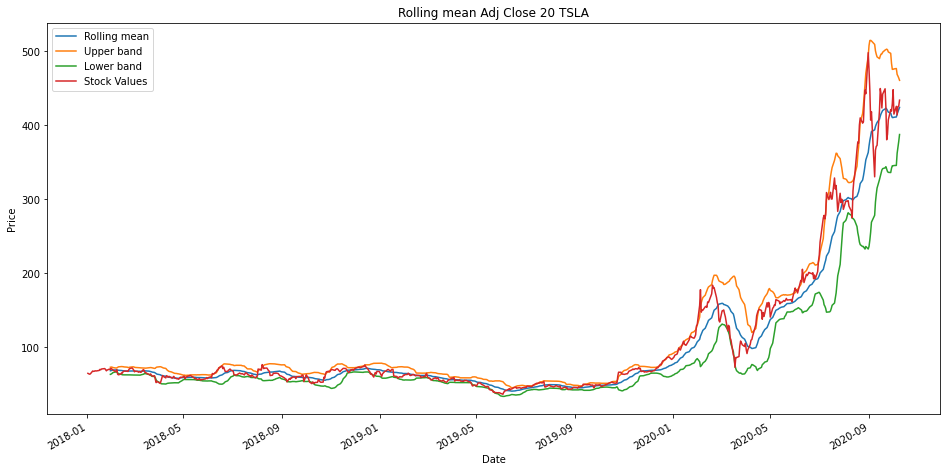

In [16]:
symbol='TSLA'
price_type = 'Adj Close'

values, rolling_mean, rolling_std, upper_band, lower_band = rolling_params(df['2018-01-01':'2020-10-10'], symbol, price_type)

plot_rolling(symbol, values, rolling_mean, upper_band, lower_band, title='Rolling mean Adj Close 20 {}'.format(symbol))
plt.show()

Comparing rolling mean and Bollinger Bands of Apple and Tesla we can see that Tesla is by far much more volatile last year.

### Look at Daily returns

We can also look at the volatility by means of comparing the range of daily returns.

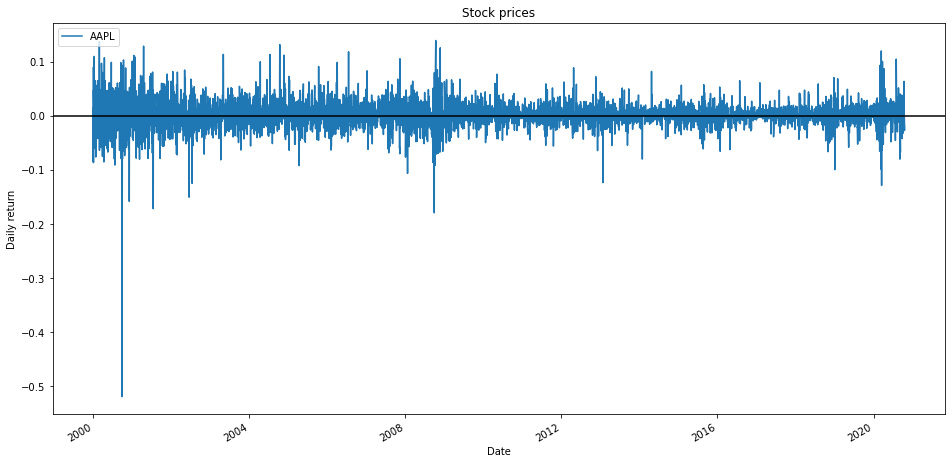

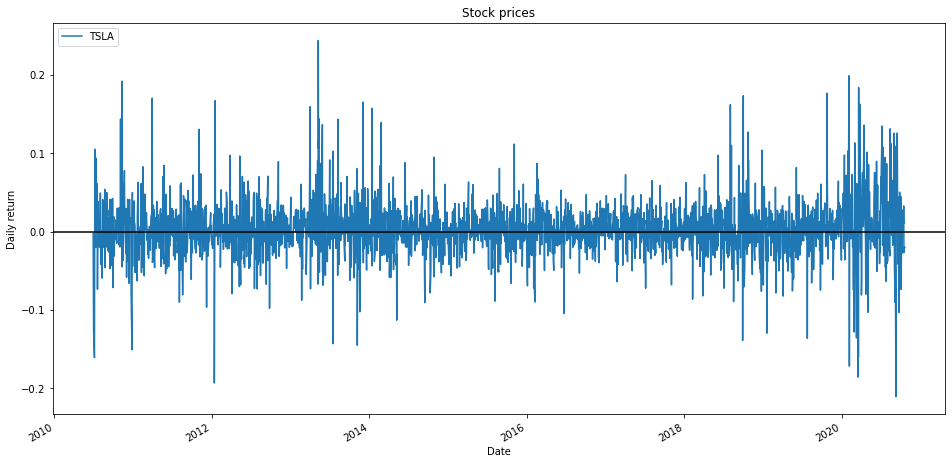

In [17]:
#Daily returns of Apple and Tesla

def daily_returns(symbol):
    '''Calculate daily returns for a given stock
    INPUT symbol - stock   OUTPUT daily returns'''
    
    daily_returns = (df[('Adj Close', symbol)][1:]/df[('Adj Close', symbol)][:-1].values)-1
    return daily_returns

plot_data(daily_returns('AAPL'), symbols=['AAPL'], ylabel='Daily return', y=0)
plt.show()

plot_data(daily_returns('TSLA'), symbols=['TSLA'], ylabel='Daily return', y=0)
plt.show()

Looking at daily returnes, we can see that range of volatility is more than twice higher for Tesla than for Apple.

### MACD

Now I would like to show how MACD (Moving Average Convergence Divergence) indicator can help predict if a stock price is going to grow of fall the next days. Divergence in this case representes a difference between two time series and represents MACD. These two time series are rolling exponential weighted means of short time period (I took 12 days) and longer time perios (I took 26). Second is substacted from the first and it is compared with exponential weighted means of even shorter time period (I took 9 days), which is called signal. So buy signal occurs when MACD is smaller than signal line, growing faster than that and line crosses signal line from below. At this point it is a Buy signal. If MACD ist above the signal line, falling faster than that and crosses it from above, it is a Sell signal.

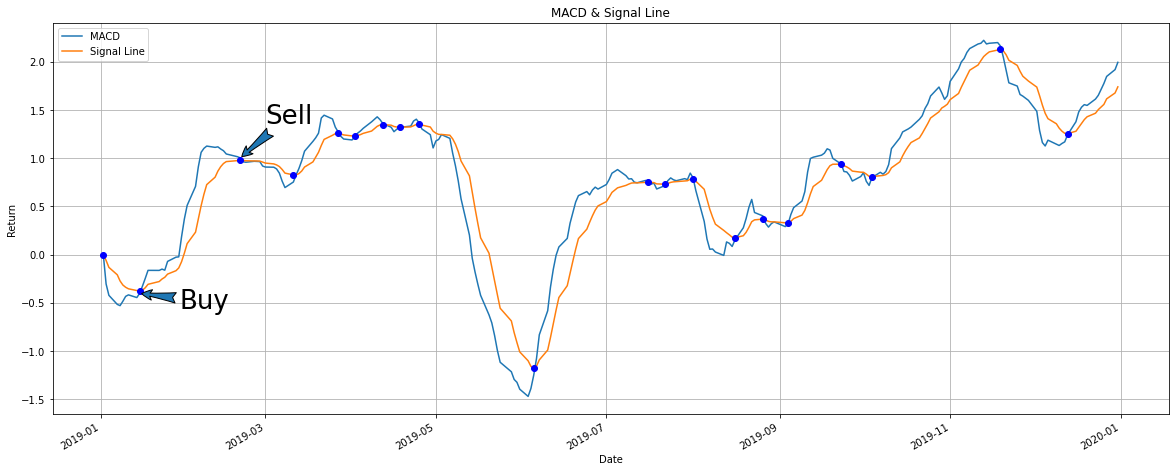

In [18]:
def calc_macd(symbol, price_type = 'Adj Close', high = 26, low = 12, sig = 9, start_date = '2019-01-01', end_date='2020-01-01'):
    '''Create macd, signal
    INPUT:
    symbol - stock
    high - high period EMA, by default 26-period EMA
    low - low period EMA, by default 12-period EMA
    price_type - type of price for which calculate parameters
    start_date - start date as datetime
    end_date - end date as datetime
    OUTPUT: macd, signal'''
 
    values = df[(price_type, symbol)][start_date:end_date]
    macd = (values.ewm(span=low, adjust=False).mean()-values.ewm(span=high, adjust=False).mean())
    signal = macd.ewm(span=sig, adjust=False).mean()
    return macd, signal

macd, signal = calc_macd('AAPL')

# plot to show MACD on the exaple of Apple
macd.plot(label='MACD', figsize=(20,8))
plt.plot(signal, label='Signal Line')
plt.grid(True)
idx = np.argwhere(np.diff(np.sign(signal - macd))).flatten()
plt.plot(macd.index[idx], signal[idx], 'bo')
plt.annotate('Buy', (mdates.date2num(macd.index[9]), macd[9]), xytext=(40, -15), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=26)
plt.annotate('Sell', (mdates.date2num(macd.index[33]), macd[33]), xytext=(25, 35), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=26)
plt.title('MACD & Signal Line')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend(loc='upper left')
plt.show()


According to MACD we should buy stocks when MACD (blue line) crosses signal line from below and sell them when MACD crosses signal line from above. Looking at the figure above we see that it would indeed work in a lot of cases.

### RSI

Another interesting technique, that could help predict stock prices movements is RSI (relative strength index). It indicates how strong is price momentum shif. It compares average losses and average gains for the previous days. RSI is calculated the following way:

RSI = 100-(100/(1+RS))

where RS is calculated as a propotion from  average gain in last 14 days to average loss in last 14 days. So, for example if it was much more loss last days, then a stock is probably goes down and it could be an indicator to sell it. Other way, if it is significantly more gains for the last days than losses, the stock price is growing and it could be a sign to buy it. RSI could be from 0 to 100. Values over 80 represent signal to buy and under 20 a signal to sell. Values in the middle are neutral and dont require for any action. 14 is a common time period used when calculating RSI, even though another time period could be chosen for calculations.

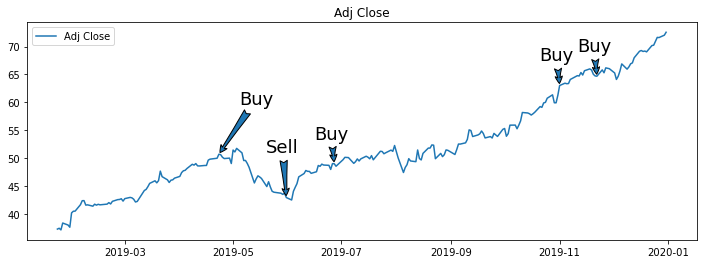

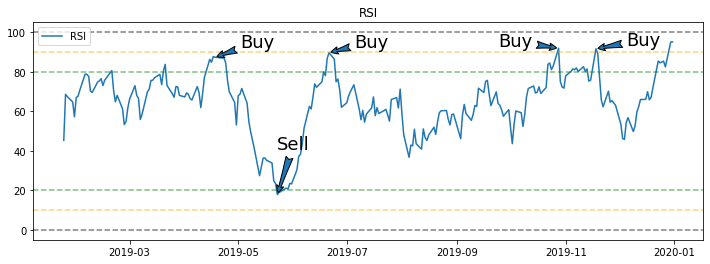

In [19]:
#Calculate RSI

def calc_RSI(symbol, price_type = 'Adj Close', time_period = 14, start_date = '2019-01-01', end_date='2020-01-01'):
    '''Calculate RSI
    INPUT:
    symbol - stock
    time_period = tim eperiod for calculation
    price_type - type of price for which calculate parameters
    start_date - start date as datetime
    end_date - end date as datetime
    OUTPUT: macd, signal'''

    delta = df[(price_type, symbol)][start_date:end_date].diff(1)
    gains, losses =  delta.copy(), delta.copy()
    gains[gains < 0] = 0 
    losses[losses > 0] = 0 
    average_gain = gains.rolling(window=time_period).mean()
    average_loss = abs(losses.rolling(window=time_period).mean())
    RS = average_gain / average_loss
    RSI = 100.0 - (100.0/ (1.0 + RS))
    return RSI

RSI = calc_RSI('AAPL')

start_date = '2019-01-01'
end_date = '2020-01-01'
time_period = 14

#Plotting the Adj Close
df1 = df[('Adj Close', 'AAPL')][start_date:end_date].iloc[time_period-1:]
plt.figure(figsize=(12,4))
plt.plot(df1, label = 'Adj Close')
plt.title('Adj Close')
plt.annotate('Buy', (mdates.date2num(df1.index[63]), df1[63]), xytext=(20, 50), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)
plt.annotate('Sell', (mdates.date2num(df1.index[90]), df1[90]), xytext=(-20, 45), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)
plt.annotate('Buy', (mdates.date2num(df1.index[109]), df1[109]), xytext=(-20, 25), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)
plt.annotate('Buy', (mdates.date2num(df1.index[198]), df1[198]), xytext=(-20, 25), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)
plt.annotate('Buy', (mdates.date2num(df1.index[213]), df1[213]), xytext=(-20, 25), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)

plt.legend(loc='upper left')
plt.show()

#Plotting the RSI
plt.figure(figsize=(12,4))
plt.title('RSI')
plt.plot(RSI, label = 'RSI')
plt.axhline(0, linestyle='--', alpha=0.5, color = 'black')
plt.axhline(10, linestyle='--', alpha=0.5, color = 'orange')
plt.axhline(20, linestyle='--', alpha=0.5, color = 'green')
plt.axhline(80, linestyle='--', alpha=0.5, color = 'green')
plt.axhline(90, linestyle='--', alpha=0.5, color = 'orange')
plt.axhline(100, linestyle='--', alpha=0.5, color = 'black')
plt.annotate('Buy', (mdates.date2num(RSI.index[74]), RSI[74]), xytext=(25, 10), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)
plt.annotate('Sell', (mdates.date2num(RSI.index[98]), RSI[98]), xytext=(0, 45), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)
plt.annotate('Buy', (mdates.date2num(RSI.index[118]), RSI[118]), xytext=(25, 6), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)
plt.annotate('Buy', (mdates.date2num(RSI.index[207]), RSI[207]), xytext=(-60, 2), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)
plt.annotate('Buy', (mdates.date2num(RSI.index[222]), RSI[222]), xytext=(30, 4), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=18)

plt.legend(loc='upper left')
plt.show()

Following RSI parameters for Apple stocks we would indeed get gain in 2019.

## Data Preprocessing for machine learning


In [20]:
# create a DataFrame for a chosen symbol and fill missing values first forward and then backward to avoid future bias
symbol = 'AAPL'

def create_ml_df(df, symbol):
    '''This function creates a Dataframe for a given stock and fills it with calculated features
    INPUT:
    df - DataFrame with stock data from yahoo finance
    symbol - true value
    OUTPUT: plot showing the relationship between predicted and true values'''

    ml_df = pd.DataFrame (data = df.iloc[:, df.columns.get_level_values(1)==symbol].values,
                          index = df.iloc[:, df.columns.get_level_values(1)==symbol].index,
                          columns = df.iloc[:, df.columns.get_level_values(1)==symbol].columns.get_level_values(0))

    ml_df.fillna(method='ffill', inplace=True) 
    ml_df.fillna(method='bfill', inplace=True)
    macd, signal = calc_macd(symbol, start_date = ml_df.index[0], end_date = ml_df.index[-1])
    ml_df['MACD'] = macd
    ml_df['Signal'] = signal

    # Add Rolling mean and Rollind std 20 for Adj Close

    ml_df['Rolling mean Adj Close 20'] = ml_df['Adj Close'].rolling(window=20).mean()
    ml_df['Rolling std Adj Close 20'] = ml_df['Adj Close'].rolling(window=20).std()
    ml_df['Low 14'] = ml_df['Adj Close'].rolling(window=14).min()
    ml_df['High 14'] = ml_df['Adj Close'].rolling(window=14).max()

    # Williams %R - Its purpose is to tell whether a stock or commodity market is trading near the high or the low,
    # or somewhere in between, of its recent trading range.

    ml_df['Williams %R'] = (ml_df['High 14']-ml_df['Adj Close'])/(ml_df['High 14']-ml_df['Low 14'])*100

    # The oscillator is from 100 up to 0. A value of 100 means the close today was the lowest low of the past N days,
    # and 0 means today's close was the highest high of the past N days.

    ml_df['RSI'] = calc_RSI(symbol, start_date = ml_df.index[0], end_date = ml_df.index[-1])

    ml_df['Returns'] = np.log(ml_df['Adj Close'] / ml_df['Adj Close'].shift())
    ml_df.dropna(inplace=True)
    
    return ml_df

## Machine learning part

Here I would like to use some machine learning technics to predict stock prices.

In [21]:
#Function to plot the comparison between y_pred and y_true
tscv = TimeSeriesSplit() # I am setting cross valudation to take into account that it works with time series data

def plot_results (y_pred , y_test , ylab = 'Return'):
    '''Plot the difference betwenn true and predicted values of the variable
    INPUT:
    y_pred - predicted value
    y_test - true value
    ylab - label of the value variable
    OUTPUT: plot showing the relationship between predicted and true values'''
    
    y_pred = pd.Series(y_pred, index = y_test.index)
    y_pred.plot(title='y_pred versus y_true', figsize=(12,4), label='y_pred')
    y_test.plot(label='y_true')
    plt.xlabel('Date')
    plt.ylabel(ylab)
    plt.legend(loc='upper left')
    plt.show()


### Machine Learning Classifier Model: SVC (Support Vector Classifier)

First I am using Support Vector Classifier to predict if the stock price goes up or down the next day, depending of the returns on the last 1 to 25 days.

In [22]:
def mod_svc_lags(ml_df_cut, start_train, end_train, start_test, end_test, lagsnum = 25):
    
    '''Calculate return values for up to 25 previous days, takes their signs as features and building a classifier model. 
    INPUT:
    ml_df_cut - dataset as DataFrame
    start_train - start date for train dataset
    end_train - end date for train dataset
    start_test - start date for test dataset
    end_test - end date for test dataset
    lagsnum - number of days for which calculate return
    OUTPUT: Accuracy of the prediction for each number of features'''
    accuracy_dict = {}
    
    for lags in range(1, lagsnum+1):
        
        ml_df1 = ml_df_cut
        cols = []
        
        for lag in range(1, lags + 1):
            col = 'lag_{}'.format(lag)
            ml_df1[col] = np.sign(ml_df1['Returns'].shift(lag))  
            cols.append(col)
        ml_df1.dropna(inplace=True)

        df_train = ml_df1[start_train: end_train]
        X_train, y_train = df_train[cols],   np.sign(df_train['Returns'])

        df_test = ml_df1[start_test: end_test]
        X_test, y_test = df_test[cols], np.sign(df_test['Returns'])

        model = SVC(gamma='scale')
        model.fit(X_train, np.sign(y_train))
        y_pred = model.predict(X_test)

        accuracy_dict[lags] = model.score(X_test, y_test)*100
        print('Correct Prediction for {} lags:'.format(lags), format(model.score(X_test, y_test)*100, '.2f'), '%')

    print('Mean accuracy is {}'.format(format(pd.Series([accuracy_dict[k] for k in accuracy_dict]).mean(), '.2f')), '%')


In [23]:
# First estimation
ml_df_svc = create_ml_df(df, 'AAPL')
mod_svc_lags(ml_df_svc, "2010-02-01", "2018-06-30", "2018-07-01", "2018-09-01", lagsnum = 25)

Correct Prediction for 1 lags: 70.45 %
Correct Prediction for 2 lags: 70.45 %
Correct Prediction for 3 lags: 61.36 %
Correct Prediction for 4 lags: 47.73 %
Correct Prediction for 5 lags: 52.27 %
Correct Prediction for 6 lags: 59.09 %
Correct Prediction for 7 lags: 47.73 %
Correct Prediction for 8 lags: 52.27 %
Correct Prediction for 9 lags: 56.82 %
Correct Prediction for 10 lags: 47.73 %
Correct Prediction for 11 lags: 52.27 %
Correct Prediction for 12 lags: 56.82 %
Correct Prediction for 13 lags: 59.09 %
Correct Prediction for 14 lags: 54.55 %
Correct Prediction for 15 lags: 47.73 %
Correct Prediction for 16 lags: 50.00 %
Correct Prediction for 17 lags: 50.00 %
Correct Prediction for 18 lags: 54.55 %
Correct Prediction for 19 lags: 59.09 %
Correct Prediction for 20 lags: 65.91 %
Correct Prediction for 21 lags: 59.09 %
Correct Prediction for 22 lags: 61.36 %
Correct Prediction for 23 lags: 61.36 %
Correct Prediction for 24 lags: 56.82 %
Correct Prediction for 25 lags: 61.36 %
Mean accu

It looks like the best prediction was for only one day lag, so that the predicting power doesnt grow with higher amount of the returnes of the previous days. Lets choose different dates to check if this distribution always works. 

In [24]:
# Second estimation
ml_df_svc = create_ml_df(df, 'AAPL')
mod_svc_lags(ml_df_svc, "2010-01-01", "2019-09-30", "2019-10-01", "2020-01-01", lagsnum = 50)

Correct Prediction for 1 lags: 64.06 %
Correct Prediction for 2 lags: 53.12 %
Correct Prediction for 3 lags: 48.44 %
Correct Prediction for 4 lags: 67.19 %
Correct Prediction for 5 lags: 62.50 %
Correct Prediction for 6 lags: 65.62 %
Correct Prediction for 7 lags: 60.94 %
Correct Prediction for 8 lags: 60.94 %
Correct Prediction for 9 lags: 56.25 %
Correct Prediction for 10 lags: 59.38 %
Correct Prediction for 11 lags: 56.25 %
Correct Prediction for 12 lags: 57.81 %
Correct Prediction for 13 lags: 64.06 %
Correct Prediction for 14 lags: 71.88 %
Correct Prediction for 15 lags: 75.00 %
Correct Prediction for 16 lags: 64.06 %
Correct Prediction for 17 lags: 70.31 %
Correct Prediction for 18 lags: 65.62 %
Correct Prediction for 19 lags: 64.06 %
Correct Prediction for 20 lags: 62.50 %
Correct Prediction for 21 lags: 65.62 %
Correct Prediction for 22 lags: 57.81 %
Correct Prediction for 23 lags: 59.38 %
Correct Prediction for 24 lags: 56.25 %
Correct Prediction for 25 lags: 51.56 %
Correct P

Looking at the different periods we can say that 1 lag that we have before doesnt have the best predictive power for the new periods as now the highest accuracy we account with 15 lags. Now it looks like more data increased predictive power. Lets check it and take some dataset with less days in training set.

In [25]:
# Third estimation
mod_svc_lags(ml_df_svc, "2015-01-01", "2019-09-30", "2019-10-01", "2020-01-01", lagsnum = 25)

Correct Prediction for 1 lags: 64.06 %
Correct Prediction for 2 lags: 40.62 %
Correct Prediction for 3 lags: 51.56 %
Correct Prediction for 4 lags: 50.00 %
Correct Prediction for 5 lags: 54.69 %
Correct Prediction for 6 lags: 43.75 %
Correct Prediction for 7 lags: 51.56 %
Correct Prediction for 8 lags: 45.31 %
Correct Prediction for 9 lags: 51.56 %
Correct Prediction for 10 lags: 51.56 %
Correct Prediction for 11 lags: 56.25 %
Correct Prediction for 12 lags: 60.94 %
Correct Prediction for 13 lags: 60.94 %
Correct Prediction for 14 lags: 64.06 %
Correct Prediction for 15 lags: 62.50 %
Correct Prediction for 16 lags: 54.69 %
Correct Prediction for 17 lags: 57.81 %
Correct Prediction for 18 lags: 59.38 %
Correct Prediction for 19 lags: 54.69 %
Correct Prediction for 20 lags: 57.81 %
Correct Prediction for 21 lags: 53.12 %
Correct Prediction for 22 lags: 56.25 %
Correct Prediction for 23 lags: 54.69 %
Correct Prediction for 24 lags: 54.69 %
Correct Prediction for 25 lags: 59.38 %
Mean accu

Comparing first and third estimations we can see that less data doesnt mean less predictive power in our case.
I also would like to conclude that the accuracy score is quite unstable and not much higher that 50% random choise so that I using this method to predict stock prices doesnt have much value.
Now I would like to use the trading parameters ('MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'Low 14', 'High 14', 'Williams %R', 'RSI') I calculated before as features and look if it makes my predictions better and also look at the combination of the both types of features.

In [26]:
ml_df = create_ml_df(df, 'AAPL')

# Function for SVC ML model

def mod_svc(ml_df, start_train, end_train, start_test, end_test, features):
    
        df_train = ml_df[start_train: end_train]
        X_train, y_train = df_train[features], np.sign(df_train['Returns'])

        df_test = ml_df[start_test: end_test]
        X_test, y_test = df_test[features], np.sign(df_test['Returns'])

        model = SVC(gamma='scale')
        model.fit(X_train, np.sign(y_train))
        y_pred = model.predict(X_test)

        print('Accuracy of Prediction:', format(model.score(X_test, y_test)*100, '.2f'), '%')      

In [27]:
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']
mod_svc(ml_df, "2014-01-01", "2018-09-30", "2018-10-01", "2019-01-01", features)
mod_svc(ml_df, "2011-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_svc(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
mod_svc(ml_df, "2010-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

Accuracy of Prediction: 68.25 %
Accuracy of Prediction: 73.02 %
Accuracy of Prediction: 75.00 %
Accuracy of Prediction: 75.00 %


In [28]:
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R',
           'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10']
mod_svc(ml_df_svc, "2014-01-01", "2018-09-30", "2018-10-01", "2019-01-01", features)
mod_svc(ml_df_svc, "2011-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_svc(ml_df_svc, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
mod_svc(ml_df_svc, "2010-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

Accuracy of Prediction: 68.25 %
Accuracy of Prediction: 68.25 %
Accuracy of Prediction: 75.00 %
Accuracy of Prediction: 75.00 %


I tried SVC with different time period and it looks to have some predictive power. Lets look how it works on other stocks that I chose in the beginning: 

In [29]:
d = {}
for stock in ['SPY', 'AAL', 'TSLA', 'F', 'MSFT', 'GOOGL', 'ACN', 'AMZN', 'JNJ', 'PFE', 'XOM', 'BA', 'GM']:
    d['ml_dl_'+stock] = create_ml_df(df, stock)
    print(stock)
    mod_svc(d['ml_dl_'+stock], "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

SPY


KeyError: "['lag_5', 'lag_9', 'lag_3', 'lag_2', 'lag_8', 'lag_7', 'lag_4', 'lag_6', 'lag_1', 'lag_10'] not in index"

Predictive power is not very high, but still at least higher than random choice for all the stocks and reaching more then 70% for some of them, so it is still a win!

### Random Forest Classifier

In [30]:
ml_df = create_ml_df(df, 'AAPL')

def mod_rfc(ml_df, start_train, end_train, start_test, end_test, features, print_acc = True):
    
        df_train = ml_df[start_train: end_train]
        X_train, y_train = df_train[features], np.sign(df_train['Returns'])

        df_test = ml_df[start_test: end_test]
        X_test, y_test = df_test[features], np.sign(df_test['Returns'])

        model = RandomForestClassifier(max_depth=2, random_state=0)
            
        model.fit(X_train, np.sign(y_train))
        
        y_pred = model.predict(X_test)
        
        if print_acc==True:
            print('Accuracy of Prediction for : ', start_train, ' - ', end_train, ' - ', start_test, ' - ',
                  end_test, '\n', format(model.score(X_test, y_test)*100, '.2f'), '%')
        return model.score(X_test, y_test)*100


I would like to look if additional lag values or more data increase predictive power of classifier.

In [31]:
#first I take only trading parameters
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']
print('Accuracy of Prediction for: ', features, '\n')

mod_rfc(ml_df, "2014-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_rfc(ml_df, "2012-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)
mod_rfc(ml_df, "2014-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)

#now I also add 5 features of lag values 
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R',
           'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
print('Accuracy of Prediction for: ', features, '\n')

mod_rfc(ml_df_svc, "2014-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_rfc(ml_df_svc, "2012-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)
mod_rfc(ml_df_svc, "2014-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)

Accuracy of Prediction for:  ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R'] 

Accuracy of Prediction for :  2014-01-01  -  2016-09-30  -  2016-10-01  -  2017-01-01 
 76.19 %
Accuracy of Prediction for :  2012-01-01  -  2020-07-31  -  2020-08-01  -  2020-10-01 
 74.42 %
Accuracy of Prediction for :  2014-01-01  -  2020-07-31  -  2020-08-01  -  2020-10-01 
 74.42 %
Accuracy of Prediction for:  ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'] 

Accuracy of Prediction for :  2014-01-01  -  2016-09-30  -  2016-10-01  -  2017-01-01 
 77.78 %
Accuracy of Prediction for :  2012-01-01  -  2020-07-31  -  2020-08-01  -  2020-10-01 
 72.09 %
Accuracy of Prediction for :  2014-01-01  -  2020-07-31  -  2020-08-01  -  2020-10-01 
 74.42 %


74.4186046511628

Scores look good. 2 more years as well as additional 5 lags as features doesn't contribute to better performance.
Now I would like to test the performance of my model. For that I first wrote a function that would generate random start/end dates for trainig and testing date (of cause making sure that test data is always in future in regard to train data).
Then I am perform a 50 loop and count mean and standard deviation of accuracy score of the model. 

In [32]:
# Function to create random dates

start_date = datetime.date(2000, 1, 1)
end_date = datetime.date(2020, 10, 20)

def rand_dates(start_date, end_date): 
    
    random_number_of_days = random.randrange((end_date - start_date).days -10)
    
    random_date_start_train = start_date + datetime.timedelta(days=random_number_of_days)
    random_number_of_days1 = random.randrange((end_date - random_date_start_train).days - 6)
    
    random_date_end_train = random_date_start_train + datetime.timedelta(days=random_number_of_days1)
    random_date_start_test = random_date_end_train + datetime.timedelta(days=1)
    random_number_of_days2 = random.randrange((end_date - random_date_start_test).days - 3)
    
    random_date_end_test = random_date_start_test + datetime.timedelta(days=random_number_of_days2)
    
    random_date_start_train = pd.to_datetime(random_date_start_train,format='%Y/%m/%d') 
    random_date_end_train = pd.to_datetime(random_date_end_train,format='%Y/%m/%d') 
    random_date_start_test = pd.to_datetime(random_date_start_test,format='%Y/%m/%d') 
    random_date_end_test = pd.to_datetime(random_date_end_test,format='%Y/%m/%d') 
    
    return random_date_start_train, random_date_end_train, random_date_start_test, random_date_end_test


In [33]:
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']

acc = []

for i in tqdm(range(1, 50)):
    random_date_start_train, random_date_end_train, random_date_start_test, random_date_end_test = rand_dates(start_date, end_date)
    acc_i = mod_rfc(ml_df, random_date_start_train, random_date_end_train, random_date_start_test,
                  random_date_end_test, features, print_acc=False)
    acc.append(acc_i)
    
acc_mean = np.mean(np.array(acc))
acc_std = np.std(np.array(acc))
print('Mean of Accuracy: ', acc_mean, 'Std of Accuracy: ', acc_std)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.38it/s]

Mean of Accuracy:  70.5502849264928 Std of Accuracy:  4.35110318293768


As Random Forest Classifier shown very good results! By testing 50 loops the accuracy is significantly highes then 50%.
Now I am going to do tuning for this model, trying to make it work even better. 

### Random Forest Classifier Tuned

In [34]:
ml_df = create_ml_df(df, 'AAPL')

def mod_rfc_tun(ml_df, start_train, end_train, start_test, end_test, features):
    
        df_train = ml_df[start_train: end_train]
        X_train, y_train = df_train[features], np.sign(df_train['Returns'])

        df_test = ml_df[start_test: end_test]
        X_test, y_test = df_test[features], np.sign(df_test['Returns'])
    
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt', None]
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
         
        model = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid,
                                       n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
        
        model.fit(X_train, np.sign(y_train))
        y_pred = model.predict(X_test)

        print('Accuracy of Prediction:', format(model.score(X_test, y_test)*100, '.2f'), '%')
        return

In [35]:
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']

print('Tuned model. Accuracy of Prediction for: ', features, '\n')
mod_rfc_tun(ml_df, "2014-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_rfc_tun(ml_df, "2012-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)
mod_rfc_tun(ml_df, "2014-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)

features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R',
           'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

print('Tuned model. Accuracy of Prediction for: ', features, '\n')
mod_rfc_tun(ml_df_svc, "2014-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_rfc_tun(ml_df_svc, "2012-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)
mod_rfc_tun(ml_df_svc, "2014-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)

Tuned model. Accuracy of Prediction for:  ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R'] 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished


Accuracy of Prediction: 82.54 %
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.3min finished


Accuracy of Prediction: 81.40 %
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Accuracy of Prediction: 76.74 %
Tuned model. Accuracy of Prediction for:  ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'] 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


Accuracy of Prediction: 74.60 %
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished


Accuracy of Prediction: 81.40 %
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Accuracy of Prediction: 81.40 %


Wow tuned model worked really great! I got results with the accuracy around 80 %. It is a very high score in comparison to what I saw in internet regarding prediction of stock prices movements. 
I can also conclude, that additional features of lags or adding additional time period in training dataset also didnt help here, so I am not going to consider them further.  
Now lets look how tuned Random Forest Classifier works on other stocks.

In [36]:
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']
d = {}
for stock in ['SPY', 'AAL', 'TSLA', 'F', 'MSFT', 'GOOGL', 'ACN', 'AMZN', 'JNJ', 'PFE', 'XOM', 'BA', 'GM']:
    d['ml_dl_'+stock] = create_ml_df(df, stock)
    print(stock)
    mod_rfc_tun(d['ml_dl_'+stock], "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

SPY
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


Accuracy of Prediction: 82.81 %
AAL
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


Accuracy of Prediction: 78.12 %
TSLA
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


Accuracy of Prediction: 78.12 %
F
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


Accuracy of Prediction: 64.06 %
MSFT
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Accuracy of Prediction: 73.44 %
GOOGL
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


Accuracy of Prediction: 79.69 %
ACN
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


Accuracy of Prediction: 76.56 %
AMZN
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


Accuracy of Prediction: 65.62 %
JNJ
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


Accuracy of Prediction: 85.94 %
PFE
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


Accuracy of Prediction: 73.44 %
XOM
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


Accuracy of Prediction: 59.38 %
BA
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


Accuracy of Prediction: 70.31 %
GM
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


Accuracy of Prediction: 71.88 %


Performance on different stocks looks also quite good, the lowest accuracy rate is around 60-70% for 3 stocks, other 4 stocks got accuracy rate of 70-75% and the prediction for rest 6 stocks is more than 75%, even up to 86%.


### Machine Learning Regressor models

Now i would like to use different machine learning models and try to predict not only the sign of the return, but also its value.

In [37]:
#First I would like to write a function to make a train/test split for a given data
ml_df = create_ml_df(df, 'AAPL')
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']

def test_train_split(ml_df, start_train, end_train, start_test, end_test, features):
    '''Split dataset in train and test
    INPUT:
    ml_df - dataset as DataFrame
    start_train - start date for train dataset
    end_train - end date for train dataset
    start_test - start date for test dataset
    end_test - end date for test dataset
    
    OUTPUT: Features datasets and variable of interest for train and test datasets'''
    
    df_train = ml_df[start_train: end_train]
    df_test = ml_df[start_test: end_test]

    X_train = df_train[features]
    y_train = df_train['Returns']
        
    X_test = df_test[features]
    y_test = df_test['Returns']
    
    return X_train, y_train, X_test, y_test

# And as the second step I wrote a function, that takes train/test data, scaler (if needed) and machine learning model as input
# and predicts values of the variable of interest. Using this model I can quickly evaluate predictive power of different ML models

def ml_model(X_train, y_train, X_test, y_test, ml_mod, scal = None):
    '''Model for given features and variable to predict 
    INPUT:
    X_train - train dataset of features
    y_train - values of the variable of interest for training
    X_test - test dataset of features
    y_test- true values of the variable for testing
    scal - preporcessing Scaler can be MinMaxScaler or RobustScaler
    ml_mod - machine learning model
    OUTPUT: predicted variable and accuracy score of the model'''

    # I have built in the possibility of Scaler as linear regression model should work better with normalised
    # and scaled data
    if scal != None: 
        model = make_pipeline(scal, ml_mod)
    else:
        model = ml_mod
                              
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    model.score(X_test, y_test)*100
    print('Accuracy of Prediction:', format(model.score(X_test, y_test)*100, '.2f'), '%')
        
    return y_pred

### SVR

Accuracy of Prediction: -240.81 %


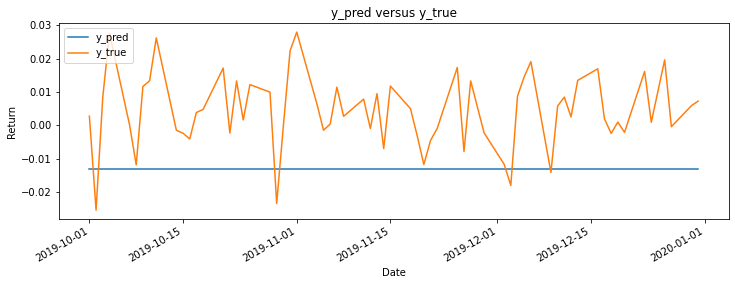

In [38]:
X_train, y_train, X_test, y_test = test_train_split(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
y_pred = ml_model(X_train, y_train, X_test, y_test, scal = RobustScaler(), ml_mod = SVR(C=1.0, epsilon=0.2))
plot_results(y_pred = y_pred, y_test = y_test)

SVR couldnt predict true returns at all.

### KNeighborsRegressor

Accuracy of Prediction: 22.32 %


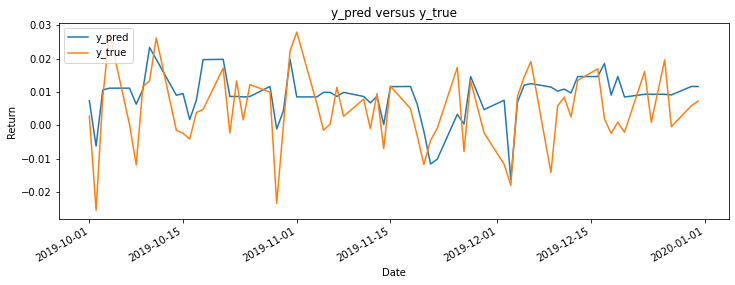

In [39]:
X_train, y_train, X_test, y_test = test_train_split(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
y_pred = ml_model(X_train, y_train, X_test, y_test, ml_mod = KNeighborsRegressor())
plot_results(y_pred = y_pred, y_test = y_test)

By KNeighbors we can recognize at least some similar muster, but it is partly shifted into the future and accuracy score is low, so the performance it quite poor.  

### Ridge Regression

Accuracy of Prediction: 25.53 %


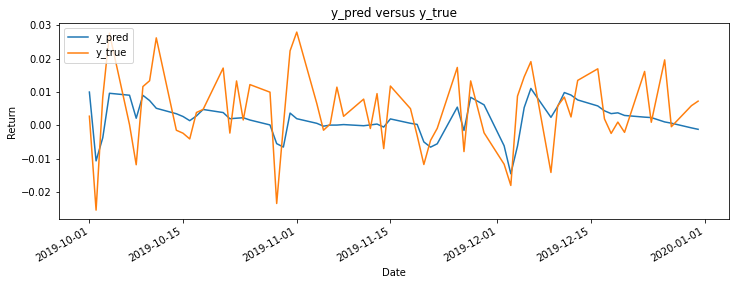

In [40]:
X_train, y_train, X_test, y_test = test_train_split(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

y_pred = ml_model(X_train, y_train, X_test, y_test, scal = RobustScaler(), ml_mod = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13), cv = tscv))

plot_results(y_pred = y_pred, y_test = y_test)


Ridge Regresion is slightly better then KNeighbors as up to accuracy score, but it is still low. The line of the predicted values also looks much more flat than true returns.

### Linear Regression

Accuracy of Prediction: 24.99 %


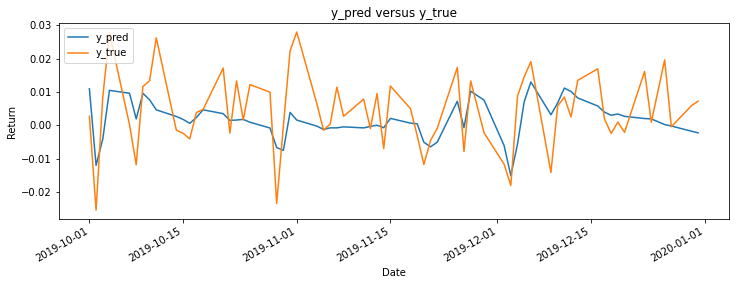

In [41]:
X_train, y_train, X_test, y_test = test_train_split(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

y_pred = ml_model(X_train, y_train, X_test, y_test, scal = RobustScaler(), ml_mod = linear_model.LinearRegression())
plot_results(y_pred = y_pred, y_test = y_test)

Similar performance as by Rdge Regression

### Random Forest

In [42]:
ml_df_svc.columns
features = ['MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'Low 14',
            'High 14', 'Williams %R', 'RSI', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
            'lag_8', 'lag_9', 'lag_10','lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
            'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25']

Accuracy of Prediction: 18.79 %


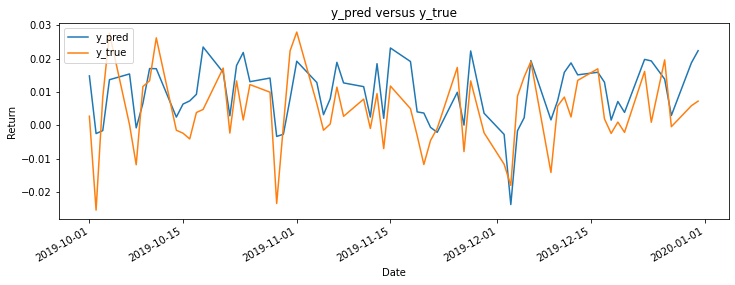

In [43]:
X_train, y_train, X_test, y_test = test_train_split(ml_df_svc, "2015-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
y_pred = ml_model(X_train, y_train, X_test, y_test, ml_mod = RandomForestRegressor())
plot_results(y_pred = y_pred, y_test = y_test)

Muster is very similar to true values but the accuracy rate is still too low.

### Neural network MLPRegressor

In [44]:
X_train, y_train, X_test, y_test = test_train_split(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
y_pred = ml_model(X_train, y_train, X_test, y_test, ml_mod = MLPRegressor(random_state=1, max_iter=500))
plot_results(y_pred = y_pred, y_test = y_test)

KeyError: "['lag_16', 'lag_3', 'lag_2', 'lag_6', 'lag_14', 'lag_9', 'lag_15', 'lag_18', 'lag_4', 'lag_13', 'lag_5', 'lag_17', 'lag_19', 'lag_20', 'lag_21', 'lag_24', 'lag_12', 'lag_23', 'lag_7', 'lag_22', 'lag_1', 'lag_10', 'lag_11', 'lag_8', 'lag_25'] not in index"

Neural network MLPRegressor didnt work for our predictions.

### ARIMA

In [45]:
lnprice = np.log(ml_df['Adj Close'])

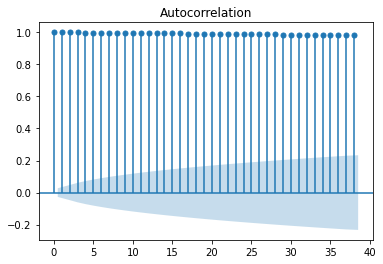

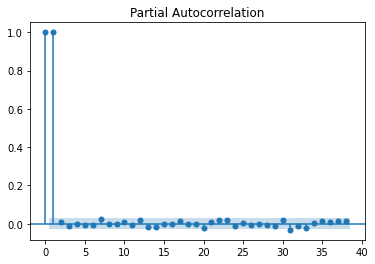

In [46]:
plot_acf(lnprice);
plot_pacf(lnprice);

In [47]:
arima = ARIMA(lnprice, order=(1,0,1))
arima_fit = arima.fit(disp=0)
#y_pred = arima_fit.predict(len(lnprice)+1, len(lnprice)+10, typ='linear')
#y_pred.plot()
arima_fit.forecast()[0]
#plot_results(y_pred = y_pred, y_test = y_test[:11])

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

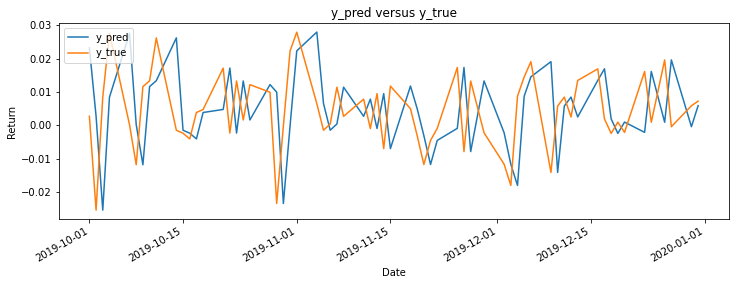

In [48]:
history = [y for y in y_train]
predictions = list()
for t in range(len(y_test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)

plot_results(y_pred = np.array(predictions).reshape(1,-1)[0], y_test = y_test)


In [49]:
ARIMA.score()

TypeError: score() missing 2 required positional arguments: 'self' and 'params'

Also ARIMA Time Series model seems not to be able to predict the values of stock prices.

# Results

**Model Evaluation and Validation**

In my research I tried to predict stock prices movements. For that I used different Machine Learning models.
Classification models seem to deliver very resilts with high predictive power of up to 80% on if a stock price is going to grow or fall the next days. 
Model that delivered the best results was Random Forest Classifier after tuning of its parameters (number of trees, minimum number of features to consider when looking for the best split and required to split an internal node, maximum depth of the tree and if or nor using Bootstraping. I got really great results using trading parameters (MACD and Signal, Rolling mean and standard deviation, RSI and Williams %R), that already according to their visualisation looked promising to predict price movements. Tuned model worked great for different time periods and for different stocks.
It turned out that longer time periods doesnt contribute to higher predicive power of the model. Also just taking laged values of returnes doest make the predictions better. It also goes hand in hand with the fact that ARIMA model didnt work for predictions as it is baced on correlation between present and laged past values of stock prices.

**Difficulties that I accounted during my project**

One of the technical difficulties I faced was when I tried to install models of keras TensorFlow.
These models looked promising in some Computer Science sources (e.g. https://www.youtube.com/watch?time_continue=1433&v=QIUxPv5PJOY&feature=emb_title) so I tried to install them. First I got Version error, after reading stackoverflow and trying to install different versions my complete Anaconda got problems so that I couldnt even install pandas. So I had to reinstall my Anaconda and decided not to try keras anymore.
Another difficulty I had is regarding to content. I found a lot of sources explaining how stock market works and how to calculate some trading parameter (including Machine Learning cource for trading, suggested by Udacity, that was interesting and expanded my understanding of stock market), but I didnt find any good source explaining which machine learning models are best to use for trading. I found a lot of tries but none of them demonstrated good performance or was explained why one works better than another. Even in books for machine learning I couldnt find it. And the last thing that was difficult is to stop trying more and more new models using more and more datasets :)

**Improvements**

My work showed that the most important is to choose right data that really can explain the variable of interest.
So as futher improvements I suggest searching for more features, that have relevance for explanaition of stock prices.
I would be also great to check the model on bigger variaty of different stocks and not only on the biggest well know companies (I didnt do it here because of the calculative power of my computer). And last but not least it would be great to find some model that not only predicts if stock price goes up or down but also the value of this movement. 
Moreover, I think it would be a great idea to write a code, using e.g. NLP to scrap news from the internet for the companies for which we want to evaluate stock prices and classify these news on scaler from -10 to +10, on which impact do these news have on the movement of stock prices. +10 for highest positive and -10 for the highest negative impacts and after that take these values as features in the predictive models. 

